In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [28]:
import constant

In [30]:
img_path = constant.LOCAL_PATH + "datasetLunares/dysplasticNevi/train/dysplasticNevi1.jpg"

In [31]:
img = cv2.imread(img_path)

In [4]:
def getFeatures(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  # buscamos el valor con el cual se diferencie el fondo de la imagen

  threshold,_ = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

  mask = np.uint8(1*(gray<threshold))

  # obtenemos las caracteristicas de la imagen entre 0 - 1
  # promedio de azul por cada pixel
  B = (1/255)*np.sum(img[:,:,0]*mask)/np.sum(mask)
  # promedio de verde por cada pixel
  G = (1/255)*np.sum(img[:,:,1]*mask)/np.sum(mask)
  # promedio de rojo por cada pixel
  R = (1/255)*np.sum(img[:,:,2]*mask)/np.sum(mask)

  return [B,G,R]

In [5]:
import glob

In [32]:
paths = [
    constant.LOCAL_PATH + "datasetLunares/dysplasticNevi/train/",
    constant.LOCAL_PATH + "datasetLunares/spitzNevus/train/"
]

In [7]:
feactures = []
labels = []

In [8]:
for label, path in enumerate(paths):
    for filename in glob.glob(path+"*.jpg"):
        img=cv2.imread(filename)
        feactures.append(getFeatures(img))
        labels.append(label)
        

In [9]:
features = np.array(feactures)
# por facilidad del modelo es mejor dejar los labels entre -1 y 1
labels = 2*np.array(labels)-1

Text(0.5, 0, 'R')

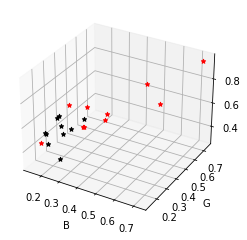

In [10]:
# visualización de las caracteristicas en un plano 3Dob
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

for i, feature_row in enumerate(features):
    if labels[i]==-1:
        ax.scatter(feature_row[0],feature_row[1],feature_row[2],marker='*', c='k')
    else:
        ax.scatter(feature_row[0],feature_row[1],feature_row[2],marker='*', c='r')
        
ax.set_xlabel('B')        
ax.set_ylabel('G')   
ax.set_zlabel('R') 

In [11]:
subFeatures=features[:,1::]
loss=[]

In [12]:
# error en funcion de las constantes del hiperplano
for w1 in np.linspace(-6,6,100):
    for w2 in np.linspace(-6,6,100):
        totalError=0
        for i,feature_row in enumerate(subFeatures):
            sample_error= (w1*feature_row[0]+w2*feature_row[1]-labels[i])**2
            totalError+=sample_error
        loss.append([w1,w2,totalError])

loss = np.array(loss)

Text(0.5, 0, 'loss')

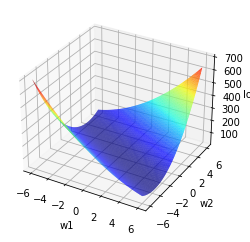

In [13]:
from matplotlib import cm
fig=plt.figure()
ax1=fig.add_subplot(111,projection='3d')

ax1.plot_trisurf(loss[:,0],loss[:,1],loss[:,2],cmap=cm.jet, linewidth=0)
ax1.set_xlabel('w1')
ax1.set_ylabel('w2')
ax1.set_zlabel('loss')

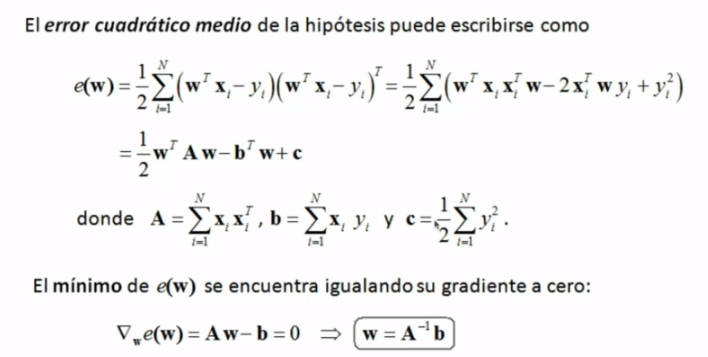

In [18]:
#calculo del hiperplano que separa las dos clases de forma optima
A=np.zeros((4,4))
b=np.zeros((4,1))

for i, feature_row in enumerate(features):
    x=np.append([1],feature_row)
    x= x.reshape((4,1))
    y=labels[i]
    A=A+x*x.T
    b=b+x*y

invA=np.linalg.inv(A)

W=np.dot(invA,b)





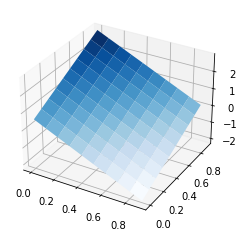

In [21]:
# plot del plano que separa los dos diferentes tipos
X=np.arange(0,1,0.1)
Y=np.arange(0,1,0.1)
X,Y=np.meshgrid(X,Y)

Z=-(W[1]*X+W[2]*Y+W[0])/W[3]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(X,Y,Z, cmap=cm.Blues)

In [22]:
#error de entrenamiento

prediction = 1*(W[0] + np.dot(features,W[1::]))>=0

prediction = 2*prediction-1

error=np.sum(prediction != labels.reshape(-1,1))/len(labels)

efectividad = 1-error

print(error, "vs", efectividad)

0.15 vs 0.85


In [33]:
#prediccion para una imagen

path_img= constant.LOCAL_PATH + 'datasetLunares/spitzNevus/train/spitzNevus5.jpg'

img=cv2.imread(path_img)

feature_vector=np.array(getFeatures(img))

result=np.sign(W[0]+np.dot(feature_vector,W[1::]))

if result == -1:
    print("es un dysplasticNevi")
else:
    print("es un spitzNevus")

es un spitzNevus
